In [29]:
from hatchet import *
import json
from state import State
from preprocess import PreProcess
import numpy as np
import utils
import random
import os
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.nonparametric.api as smnp

In [3]:
dirname = '/Users/jarus/ucd/Research/Visualisation/projects/CallFlow/.callflow'
# dirname = '/home/vidi/Work/llnl/CallFlow/.callflow'
dataset = 'calc-pi'

In [4]:
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:,.2f}'.format

# Read entire dataset

In [5]:
def replace_str_with_Node(df, graph):
        mapper = {}
        def dfs_recurse(root):
            for node in root.children: 
                mapper[node.callpath[-1]] = Node(node.nid, node.callpath, None)
                dfs_recurse(node)
        for root in graph.roots:
            mapper[root.callpath[-1]] = Node(root.nid, root.callpath, None)
            dfs_recurse(root)
        df['node'] = df['node'].apply(lambda node: mapper[node] if node in mapper else '')
        return df

In [6]:
def write_gf(state, state_name, format_of_df, write_graph=True):
    print('writing file for {0} format'.format(format_of_df))

    if write_graph:
        # dump the entire_graph as literal
        graph_literal = state.graph.to_literal(graph=state.graph, dataframe=state.df)
        graph_filepath = dirname + '/' + state_name + '/' + format_of_df + '_graph.json'
        print('File path: {0}'.format(graph_filepath))
        with open(graph_filepath, 'w') as graphFile:
            json.dump(graph_literal, graphFile)

    # dump the filtered dataframe to csv.
    df_filepath = dirname + '/' + state_name + '/' + format_of_df + '_df.csv'
    state.df.to_csv(df_filepath)

In [7]:
def read_gf(name):
    state = State()
    df_filepath = dirname + '/' + name +  '/filter_df.csv'
    entire_df_filepath = dirname + '/' + name + '/entire_df.csv'
    graph_filepath = dirname + '/' + name + '/filter_graph.json'
    entire_graph_filepath = dirname + '/' + name + '/entire_graph.json'   
    group_df_filepath = dirname + '/' + name + '/group_df.csv'

    with open(graph_filepath, 'r') as graphFile:
        data = json.load(graphFile)

    state.gf = GraphFrame()
    state.gf.from_literal_persist(data)

    with open(entire_graph_filepath, 'r') as entire_graphFile:
        entire_data = json.load(entire_graphFile)
            
    state.entire_gf = GraphFrame()
    state.entire_gf.from_literal_persist(entire_data)

    state.df = pd.read_csv(df_filepath)
    state.entire_df = pd.read_csv(entire_df_filepath)

    state.graph = state.gf.graph
    state.entire_graph = state.entire_gf.graph

    # replace df['node'] from str to the Node object.
    state.df = replace_str_with_Node(state.df, state.graph)
    state.entire_df = replace_str_with_Node(state.entire_df, state.entire_graph)
    
    state.group_df = pd.read_csv(group_df_filepath)

    return state

In [8]:
##############################################################################
# Copyright (c) 2018-2019, Lawrence Livermore National Security, LLC.
# Produced at the Lawrence Livermore National Laboratory.
#
# This file is part of Callflow.
# Created by Suraj Kesavan <kesavan1@llnl.gov>.
# LLNL-CODE-741008. All rights reserved.
#
# For details, see: https://github.com/LLNL/Callflow
# Please also read the LICENSE file for the MIT License notice.
##############################################################################

#!/usr/bin/env python3

import pandas as pd
import time 
import utils
from logger import log

class Filter:
    '''
    Filter the graphframe.
    Input: State object, parameter to filterBy (could be inclusive/exclusive, 
            filterPerc: user provided filter percentage (1-100))
    '''
    def __init__(self, state, filterBy, filterPerc):
        utils.debug('filter By:', filterBy)
        utils.debug('filter Perc:', filterPerc)
        self.state = state
        self.graph = state.entire_graph
        self.df = state.entire_df
        self.gf = state.entire_gf

        self.df.set_index(['node', 'rank'], drop=False, inplace=True)

        # self.df = pd.MultiIndex.from_frame(self.df, names=['node', 'rank'])
        self.gf.dataframe = self.df
        
        self.filterBy = filterBy
        self.filterPercInDecimals = int(filterPerc)/100
        # self.filterPercInDecimals = 0.001 
        
        self.fgf = self.run() 
        self.fgf = self.graft()

        # update df and graph after filtering.
        self.df = self.fgf.dataframe
        self.graph = self.fgf.graph

    def run(self):
        log.info('Filtering the graph.')
        t = time.time()
        if self.filterBy == "Inclusive":
            max_inclusive_time = utils.getMaxIncTime_from_gf(self.graph, self.df)
            filter_gf = self.gf.filter(lambda x: True if(x['time (inc)'] > self.filterPercInDecimals*max_inclusive_time) else False)
        elif filterBy == "Exclusive":
            max_exclusive_time = utils.getMaxExcTime_from_gf(self.graph, self.df)
            log.info('[Filter] By Exclusive time = {0})'.format(max_exclusive_time))
            filter_gf = self.gf.filter(lambda x: True if (x['time'] >= self.filterPercInDecimals*max_exclusive_time) else False)
        else:
            log.warn("Not filtering.... Can take forever. Thou were warned")
            filter_gf = self.gf
        
        log.info('[Filter] Removed {0} rows. (time={1})'.format(self.gf.dataframe.shape[0] - filter_gf.dataframe.shape[0], time.time() - t))

        return filter_gf

    def graft(self):
        log.info("Squashing the graph.")
        t = time.time()
        fgf = self.fgf.squash()
        log.info("[Squash] {1} rows in dataframe (time={0})".format(time.time() - t, fgf.dataframe.shape[0]))
        return fgf

In [9]:
def ffilter(state, filterBy, filterPerc):
        filter_obj = Filter(state, filterBy, filterPerc)

        state.gf = filter_obj.gf
        state.df = filter_obj.df
        state.graph = filter_obj.graph

        return state

In [10]:
state = read_gf(dataset)

In [11]:
print(state.df)

                   node  rank   time (inc)       time  nid  rank.1  \
0        <program root>     0   999,238.00       0.00    2       0   
1        <program root>     1   999,390.00       0.00    2       1   
2        <program root>     2 1,000,306.00       0.00    2       2   
3        <program root>     3   999,308.00       0.00    2       3   
4                  main     0   999,238.00       0.00    4       0   
..                  ...   ...          ...        ...  ...     ...   
63  <unknown procedure>     3   173,876.00       0.00   54       3   
64     <unknown file>:0     0   197,718.00 197,718.00   55       0   
65     <unknown file>:0     1   244,939.00 244,939.00   55       1   
66     <unknown file>:0     2   221,846.00 221,846.00   55       2   
67     <unknown file>:0     3   173,876.00 173,876.00   55       3   

                   name type            file  line                     module  \
0        <program root>   PF  <unknown file>     0        libmonitor.so.0.0.0 

# Half-calc-pi dataset

In [12]:
def setvalues(state):
    random = pd.Series(np.random.rand(state.df.shape[0]))
    print(random)
    state.df['time (inc)'] = state.df['time (inc)']*random
    state.df['time'] = state.df['time']*random
    state.entire_df['time (inc)'] = state.entire_df['time (inc)']*random
    state.entire_df['time'] = state.entire_df['time']*random
    state.group_df['time (inc)'] = state.group_df['time (inc)']*random
    return state

In [13]:
def create_dot_callflow_folder(dataset):
            dataset_dir = dirname + '/' + dataset
            if not os.path.exists(dataset_dir):
                utils.debug('Creating .callflow directory for dataset : {0}'.format(dataset))
                os.makedirs(dataset_dir)
    
            files = ["entire_df.csv", "filter_df.csv", "entire_graph.json", "filter_graph.json", "group_df.csv"]
            for f in files:
                if not os.path.exists(dataset_dir + '/' + f):
                    open(os.path.join(dataset_dir, f), 'w').close()

In [14]:
def create_n_runs(incoming_dataset, n, filterBy, filterPerc):
    states = {}
    for i in range(0, n):
        print("Reading dataset: ", incoming_dataset)
        state = read_gf(incoming_dataset)
        dataset = incoming_dataset + '-random-' + str(i)
        create_dot_callflow_folder(dataset)
        state = setvalues(state)
        states[dataset] = state
        write_gf(state, dataset, 'entire')
        print("Writing to entire dataset: ", dataset)
        state = ffilter(state, filterBy, filterPerc) 
        print("Writing to filter dataset: ", dataset)
        write_gf(state, dataset, 'filter')
        df_filepath = dirname + '/' + dataset + '/' +'group_df.csv'
        state.group_df.to_csv(df_filepath)
    return states

In [17]:
states = create_n_runs('calc-pi', 10, 'Inclusive', 1)

Reading dataset:  calc-pi
0    0.37
1    0.90
2    0.82
3    0.07
4    0.85
     ... 
63   0.68
64   0.01
65   0.68
66   0.73
67   0.11
Length: 68, dtype: float64
writing file for entire format
DFS on the graph
Root = <program root> [2]
Node = main[Module = cpi:4] time (inc) = 677579.8314457001 time = 0.0
- Node = 62:MPI_Finalize[Module = libmonitor.so.0.0.0:27] time (inc) = 331418.43255056196 time = 0.0
- - Node = PMPI_Finalize[Module = libmpi.so.12.0.5:29] time (inc) = 551956.7946590802 time = 0.0
- - - Node = 294:MPID_Finalize[Module = libmpi.so.12.0.5:31] time (inc) = 307157.8536952463 time = 0.0
- - - - Node = 162:MPIDI_CH3_Finalize[Module = libmpi.so.12.0.5:33] time (inc) = 358790.4221599924 time = 0.0
- - - - - Node = 230:psm_dofinalize[Module = libmpi.so.12.0.5:35] time (inc) = 439026.59263182676 time = 0.0
- - - - - - Node = 36:<unknown procedure>[Module = libpsm_infinipath.so.1.14:37] time (inc) = 495994.78137051367 time = 0.0
- - - - - - - Node = <unknown procedure>[Module =

 CallFlow:   [callfow.py] Action: filter By: "Inclusive"
 CallFlow:   [callfow.py] Action: filter Perc: 1
 CallFlow:  Filtering the graph.
 CallFlow:  [Filter] Removed 114 rows. (time=0.04448270797729492)
 CallFlow:  Squashing the graph.
 CallFlow:  [Squash] 22 rows in dataframe (time=0.06285905838012695)


 49
<unknown procedure> 54
                   node  rank  time (inc)  time  nid  rank.1  \
60  <unknown procedure>     0   28,551.94  0.00   54       0   
61  <unknown procedure>     1  210,158.03  0.00   54       1   
62  <unknown procedure>     2   41,011.02  0.00   54       2   
63  <unknown procedure>     3  118,505.98  0.00   54       3   

                   name type            file  line                     module  \
60  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   
61  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   
62  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   
63  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   

                 node.1  n_index  mod_index  \
60  <unknown procedure>       28          2   
61  <unknown procedure>       28          2   
62  <unknown procedure>       28          2   
63  <unknown procedure>       28          2   

          

Reading dataset:  calc-pi
0    0.56
1    0.03
2    0.67
3    0.94
4    0.92
     ... 
63   0.11
64   0.15
65   0.46
66   0.22
67   0.98
Length: 68, dtype: float64
writing file for entire format
DFS on the graph
Root = <program root> [2]
Node = main[Module = cpi:4] time (inc) = 504853.67313883314 time = 0.0
- Node = 62:MPI_Finalize[Module = libmonitor.so.0.0.0:27] time (inc) = 566724.097698301 time = 0.0
- - Node = PMPI_Finalize[Module = libmpi.so.12.0.5:29] time (inc) = 632937.8628521508 time = 0.0
- - - Node = 294:MPID_Finalize[Module = libmpi.so.12.0.5:31] time (inc) = 464784.72725034907 time = 0.0
- - - - Node = 162:MPIDI_CH3_Finalize[Module = libmpi.so.12.0.5:33] time (inc) = 826324.0018789435 time = 0.0
- - - - - Node = 230:psm_dofinalize[Module = libmpi.so.12.0.5:35] time (inc) = 537964.0810919898 time = 0.0
- - - - - - Node = 36:<unknown procedure>[Module = libpsm_infinipath.so.1.14:37] time (inc) = 463292.6898587374 time = 0.0
- - - - - - - Node = <unknown procedure>[Module = l

 CallFlow:   [callfow.py] Action: filter By: "Inclusive"
 CallFlow:   [callfow.py] Action: filter Perc: 1
 CallFlow:  Filtering the graph.
 CallFlow:  [Filter] Removed 112 rows. (time=0.0525970458984375)
 CallFlow:  Squashing the graph.
 CallFlow:  [Squash] 24 rows in dataframe (time=0.0676429271697998)


                   node  rank  time (inc)  time  nid  rank.1  \
60  <unknown procedure>     0  123,024.62  0.00   54       0   
61  <unknown procedure>     1   16,376.90  0.00   54       1   
62  <unknown procedure>     2   11,863.91  0.00   54       2   
63  <unknown procedure>     3   19,475.05  0.00   54       3   

                   name type            file  line                     module  \
60  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   
61  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   
62  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   
63  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   

                 node.1  n_index  mod_index  \
60  <unknown procedure>       28          2   
61  <unknown procedure>       28          2   
62  <unknown procedure>       28          2   
63  <unknown procedure>       28          2   

                                     

Reading dataset:  calc-pi
0    0.45
1    0.62
2    0.43
3    0.83
4    0.12
     ... 
63   0.17
64   0.98
65   0.89
66   0.41
67   0.82
Length: 68, dtype: float64
writing file for entire format
DFS on the graph
Root = <program root> [2]
Node = main[Module = cpi:4] time (inc) = 376552.7570840869 time = 0.0
- Node = 62:MPI_Finalize[Module = libmonitor.so.0.0.0:27] time (inc) = 412062.990881186 time = 0.0
- - Node = PMPI_Finalize[Module = libmpi.so.12.0.5:29] time (inc) = 687799.6812314419 time = 0.0
- - - Node = 294:MPID_Finalize[Module = libmpi.so.12.0.5:31] time (inc) = 398268.0143472628 time = 0.0
- - - - Node = 162:MPIDI_CH3_Finalize[Module = libmpi.so.12.0.5:33] time (inc) = 505472.38867684314 time = 0.0
- - - - - Node = 230:psm_dofinalize[Module = libmpi.so.12.0.5:35] time (inc) = 469493.0897119849 time = 0.0
- - - - - - Node = 36:<unknown procedure>[Module = libpsm_infinipath.so.1.14:37] time (inc) = 241417.67544388087 time = 0.0
- - - - - - - Node = <unknown procedure>[Module = l

 CallFlow:   [callfow.py] Action: filter By: "Inclusive"
 CallFlow:   [callfow.py] Action: filter Perc: 1
 CallFlow:  Filtering the graph.
 CallFlow:  [Filter] Removed 112 rows. (time=0.041905879974365234)
 CallFlow:  Squashing the graph.
 CallFlow:  [Squash] 24 rows in dataframe (time=0.05007624626159668)


                   node  rank  time (inc)  time  nid  rank.1  \
48  <unknown procedure>     0  212,353.76  0.00   49       0   
49  <unknown procedure>     1   44,523.98  0.00   49       1   
50  <unknown procedure>     2  239,081.57  0.00   49       2   
51  <unknown procedure>     3  119,885.31  0.00   49       3   

                   name type            file  line                     module  \
48  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   
49  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   
50  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   
51  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   

                 node.1  n_index  mod_index  \
48  <unknown procedure>       25          2   
49  <unknown procedure>       25          2   
50  <unknown procedure>       25          2   
51  <unknown procedure>       25          2   

                                     

Reading dataset:  calc-pi
0    0.61
1    0.90
2    0.35
3    0.74
4    0.12
     ... 
63   0.95
64   0.42
65   0.01
66   0.79
67   0.98
Length: 68, dtype: float64
writing file for entire format
DFS on the graph
Root = <program root> [2]
Node = main[Module = cpi:4] time (inc) = 415260.35156004294 time = 0.0
- Node = 62:MPI_Finalize[Module = libmonitor.so.0.0.0:27] time (inc) = 422076.62914927606 time = 0.0
- - Node = PMPI_Finalize[Module = libmpi.so.12.0.5:29] time (inc) = 407738.0894705265 time = 0.0
- - - Node = 294:MPID_Finalize[Module = libmpi.so.12.0.5:31] time (inc) = 521535.86631960084 time = 0.0
- - - - Node = 162:MPIDI_CH3_Finalize[Module = libmpi.so.12.0.5:33] time (inc) = 671984.9755009382 time = 0.0
- - - - - Node = 230:psm_dofinalize[Module = libmpi.so.12.0.5:35] time (inc) = 450823.8739220904 time = 0.0
- - - - - - Node = 36:<unknown procedure>[Module = libpsm_infinipath.so.1.14:37] time (inc) = 484931.60567474505 time = 0.0
- - - - - - - Node = <unknown procedure>[Module 

 CallFlow:   [callfow.py] Action: filter By: "Inclusive"
 CallFlow:   [callfow.py] Action: filter Perc: 1
 CallFlow:  Filtering the graph.
 CallFlow:  [Filter] Removed 112 rows. (time=0.029159069061279297)
 CallFlow:  Squashing the graph.
 CallFlow:  [Squash] 24 rows in dataframe (time=0.06366205215454102)


                node  rank  time (inc)       time  nid  rank.1  \
56  <unknown file>:0     0  262,252.61 262,252.61   47       0   
57  <unknown file>:0     1   30,728.47  30,728.47   47       1   
58  <unknown file>:0     2  180,334.63 180,334.63   47       2   
59  <unknown file>:0     3   61,493.49  61,493.49   47       3   

                name type            file  line       module  \
56  <unknown file>:0    S  <unknown file>     0  Unknown(NA)   
57  <unknown file>:0    S  <unknown file>     0  Unknown(NA)   
58  <unknown file>:0    S  <unknown file>     0  Unknown(NA)   
59  <unknown file>:0    S  <unknown file>     0  Unknown(NA)   

              node.1  n_index  mod_index callees  \
56  <unknown file>:0       24         -1      []   
57  <unknown file>:0       24         -1      []   
58  <unknown file>:0       24         -1      []   
59  <unknown file>:0       24         -1      []   

                                              callers  show_node  \
56  ['pthread_creat

Reading dataset:  calc-pi
0    0.50
1    0.21
2    0.27
3    0.91
4    0.50
     ... 
63   0.63
64   0.83
65   0.76
66   0.07
67   0.87
Length: 68, dtype: float64
writing file for entire format
DFS on the graph
Root = <program root> [2]
Node = main[Module = cpi:4] time (inc) = 727589.5207654266 time = 0.0
- Node = 62:MPI_Finalize[Module = libmonitor.so.0.0.0:27] time (inc) = 591012.0357948581 time = 0.0
- - Node = PMPI_Finalize[Module = libmpi.so.12.0.5:29] time (inc) = 873404.999364283 time = 0.0
- - - Node = 294:MPID_Finalize[Module = libmpi.so.12.0.5:31] time (inc) = 628212.2909226669 time = 0.0
- - - - Node = 162:MPIDI_CH3_Finalize[Module = libmpi.so.12.0.5:33] time (inc) = 392086.5485201672 time = 0.0
- - - - - Node = 230:psm_dofinalize[Module = libmpi.so.12.0.5:35] time (inc) = 525551.4403792609 time = 0.0
- - - - - - Node = 36:<unknown procedure>[Module = libpsm_infinipath.so.1.14:37] time (inc) = 353330.63205490133 time = 0.0
- - - - - - - Node = <unknown procedure>[Module = li

 CallFlow:   [callfow.py] Action: filter By: "Inclusive"
 CallFlow:   [callfow.py] Action: filter Perc: 1
 CallFlow:  Filtering the graph.
 CallFlow:  [Filter] Removed 112 rows. (time=0.03861236572265625)
 CallFlow:  Squashing the graph.
 CallFlow:  [Squash] 24 rows in dataframe (time=0.05648612976074219)


                node  rank  time (inc)       time  nid  rank.1  \
52  <unknown file>:0     0  231,595.85 231,595.85   44       0   
53  <unknown file>:0     1  131,350.48 131,350.48   44       1   
54  <unknown file>:0     2  231,457.15 231,457.15   44       2   
55  <unknown file>:0     3  293,408.34 293,408.34   44       3   

                name type            file  line       module  \
52  <unknown file>:0    S  <unknown file>     0  Unknown(NA)   
53  <unknown file>:0    S  <unknown file>     0  Unknown(NA)   
54  <unknown file>:0    S  <unknown file>     0  Unknown(NA)   
55  <unknown file>:0    S  <unknown file>     0  Unknown(NA)   

              node.1  n_index  mod_index callees  \
52  <unknown file>:0       22         -1      []   
53  <unknown file>:0       22         -1      []   
54  <unknown file>:0       22         -1      []   
55  <unknown file>:0       22         -1      []   

                                              callers  show_node  \
52  ['pthread_creat

                  3     (('<program root>', 'main', '62:MPI_Finalize',...   31
162:MPIDI_CH3_Finalize 33
                                               node  rank  time (inc)  time  \
node                   rank                                                   
162:MPIDI_CH3_Finalize 0     162:MPIDI_CH3_Finalize     0  829,455.67  0.00   
                       1     162:MPIDI_CH3_Finalize     1  754,836.01  0.00   
                       2     162:MPIDI_CH3_Finalize     2   65,628.91  0.00   
                       3     162:MPIDI_CH3_Finalize     3  865,905.06  0.00   

                             nid  rank.1                    name type  \
node                   rank                                             
162:MPIDI_CH3_Finalize 0      33       0  162:MPIDI_CH3_Finalize   PF   
                       1      33       1  162:MPIDI_CH3_Finalize   PF   
                       2      33       2  162:MPIDI_CH3_Finalize   PF   
                       3      33       3  162:MPIDI_CH3

 CallFlow:   [callfow.py] Action: filter By: "Inclusive"
 CallFlow:   [callfow.py] Action: filter Perc: 1
 CallFlow:  Filtering the graph.
 CallFlow:  [Filter] Removed 113 rows. (time=0.032282114028930664)
 CallFlow:  Squashing the graph.
 CallFlow:  [Squash] 23 rows in dataframe (time=0.0585939884185791)


 55
<unknown procedure> 46
                   node  rank  time (inc)  time  nid  rank.1  \
44  <unknown procedure>     0  114,832.85  0.00   46       0   
45  <unknown procedure>     1  170,302.92  0.00   46       1   
46  <unknown procedure>     2  207,023.58  0.00   46       2   
47  <unknown procedure>     3  307,179.73  0.00   46       3   

                   name type            file  line                     module  \
44  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   
45  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   
46  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   
47  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   

                 node.1  n_index  mod_index  \
44  <unknown procedure>       23          2   
45  <unknown procedure>       23          2   
46  <unknown procedure>       23          2   
47  <unknown procedure>       23          2   

          

Reading dataset:  calc-pi
0    0.10
1    0.88
2    0.96
3    0.70
4    0.14
     ... 
63   0.79
64   0.30
65   0.77
66   0.51
67   0.60
Length: 68, dtype: float64
writing file for entire format
DFS on the graph
Root = <program root> [2]
Node = main[Module = cpi:4] time (inc) = 364705.7433501609 time = 0.0
- Node = 62:MPI_Finalize[Module = libmonitor.so.0.0.0:27] time (inc) = 558420.1716902708 time = 0.0
- - Node = PMPI_Finalize[Module = libmpi.so.12.0.5:29] time (inc) = 237832.55142799355 time = 0.0
- - - Node = 294:MPID_Finalize[Module = libmpi.so.12.0.5:31] time (inc) = 633822.8377581879 time = 0.0
- - - - Node = 162:MPIDI_CH3_Finalize[Module = libmpi.so.12.0.5:33] time (inc) = 619802.1470551118 time = 0.0
- - - - - Node = 230:psm_dofinalize[Module = libmpi.so.12.0.5:35] time (inc) = 481199.81795477634 time = 0.0
- - - - - - Node = 36:<unknown procedure>[Module = libpsm_infinipath.so.1.14:37] time (inc) = 720567.785815415 time = 0.0
- - - - - - - Node = <unknown procedure>[Module = l

 CallFlow:   [callfow.py] Action: filter By: "Inclusive"
 CallFlow:   [callfow.py] Action: filter Perc: 1
 CallFlow:  Filtering the graph.
 CallFlow:  [Filter] Removed 113 rows. (time=0.03159785270690918)
 CallFlow:  Squashing the graph.
 CallFlow:  [Squash] 23 rows in dataframe (time=0.06552577018737793)


 47
File path: /Users/jarus/ucd/Research/Visualisation/projects/CallFlow/.callflow/calc-pi-random-6/entire_graph.json
Writing to entire dataset:  calc-pi-random-6
<program root>
                               node  rank  time (inc)  time  nid  rank.1  \
node           rank                                                        
<program root> 0     <program root>     0  104,017.97  0.00    2       0   
               1     <program root>     1  876,757.80  0.00    2       1   
               2     <program root>     2  959,169.93  0.00    2       2   
               3     <program root>     3  696,798.31  0.00    2       3   

                               name type            file  line  \
node           rank                                              
<program root> 0     <program root>   PF  <unknown file>     0   
               1     <program root>   PF  <unknown file>     0   
               2     <program root>   PF  <unknown file>     0   
               3     <program root>

Reading dataset:  calc-pi
0    0.35
1    0.10
2    0.20
3    0.60
4    0.35
     ... 
63   0.10
64   0.49
65   0.32
66   0.21
67   0.05
Length: 68, dtype: float64
writing file for entire format
DFS on the graph
Root = <program root> [2]
Node = main[Module = cpi:4] time (inc) = 585728.7455182503 time = 0.0
- Node = 62:MPI_Finalize[Module = libmonitor.so.0.0.0:27] time (inc) = 365401.53688293154 time = 0.0
- - Node = PMPI_Finalize[Module = libmpi.so.12.0.5:29] time (inc) = 552224.9321348945 time = 0.0
- - - Node = 294:MPID_Finalize[Module = libmpi.so.12.0.5:31] time (inc) = 564715.243331399 time = 0.0
- - - - Node = 162:MPIDI_CH3_Finalize[Module = libmpi.so.12.0.5:33] time (inc) = 435748.41903774365 time = 0.0
- - - - - Node = 230:psm_dofinalize[Module = libmpi.so.12.0.5:35] time (inc) = 477598.033405302 time = 0.0
- - - - - - Node = 36:<unknown procedure>[Module = libpsm_infinipath.so.1.14:37] time (inc) = 474010.9986346114 time = 0.0
- - - - - - - Node = <unknown procedure>[Module = li

 CallFlow:   [callfow.py] Action: filter By: "Inclusive"
 CallFlow:   [callfow.py] Action: filter Perc: 1
 CallFlow:  Filtering the graph.
 CallFlow:  [Filter] Removed 112 rows. (time=0.05063486099243164)
 CallFlow:  Squashing the graph.
 CallFlow:  [Squash] 24 rows in dataframe (time=0.054811954498291016)


                node  rank  time (inc)       time  nid  rank.1  \
52  <unknown file>:0     0  156,405.73 156,405.73   44       0   
53  <unknown file>:0     1  132,998.44 132,998.44   44       1   
54  <unknown file>:0     2  143,907.52 143,907.52   44       2   
55  <unknown file>:0     3   37,154.71  37,154.71   44       3   

                name type            file  line       module  \
52  <unknown file>:0    S  <unknown file>     0  Unknown(NA)   
53  <unknown file>:0    S  <unknown file>     0  Unknown(NA)   
54  <unknown file>:0    S  <unknown file>     0  Unknown(NA)   
55  <unknown file>:0    S  <unknown file>     0  Unknown(NA)   

              node.1  n_index  mod_index callees  \
52  <unknown file>:0       22         -1      []   
53  <unknown file>:0       22         -1      []   
54  <unknown file>:0       22         -1      []   
55  <unknown file>:0       22         -1      []   

                                              callers  show_node  \
52  ['pthread_creat

                                 node  rank  time (inc)  time  nid  rank.1  \
node            rank                                                         
62:MPI_Finalize 0     62:MPI_Finalize     0  523,036.86  0.00   27       0   
                1     62:MPI_Finalize     1  452,458.28  0.00   27       1   
                2     62:MPI_Finalize     2  452,870.10  0.00   27       2   
                3     62:MPI_Finalize     3  119,458.05  0.00   27       3   

                                 name type            file  line  \
node            rank                                               
62:MPI_Finalize 0     62:MPI_Finalize   PF  <unknown file>     0   
                1     62:MPI_Finalize   PF  <unknown file>     0   
                2     62:MPI_Finalize   PF  <unknown file>     0   
                3     62:MPI_Finalize   PF  <unknown file>     0   

                                   module           node.1  n_index  \
node            rank                               

 CallFlow:   [callfow.py] Action: filter By: "Inclusive"
 CallFlow:   [callfow.py] Action: filter Perc: 1
 CallFlow:  Filtering the graph.
 CallFlow:  [Filter] Removed 112 rows. (time=0.052018165588378906)
 CallFlow:  Squashing the graph.
 CallFlow:  [Squash] 24 rows in dataframe (time=0.04710865020751953)


 43
                   node  rank  time (inc)  time  nid  rank.1  \
40  <unknown procedure>     0  218,507.44  0.00   43       0   
41  <unknown procedure>     1  121,515.57  0.00   43       1   
42  <unknown procedure>     2  158,790.50  0.00   43       2   
43  <unknown procedure>     3  232,213.24  0.00   43       3   

                   name type            file  line                     module  \
40  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   
41  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   
42  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   
43  <unknown procedure>   PF  <unknown file>     0  libpsm_infinipath.so.1.14   

                 node.1  n_index  mod_index  \
40  <unknown procedure>       21          2   
41  <unknown procedure>       21          2   
42  <unknown procedure>       21          2   
43  <unknown procedure>       21          2   

                                 

Reading dataset:  calc-pi
0    0.32
1    0.49
2    0.66
3    0.12
4    0.99
     ... 
63   0.19
64   0.71
65   0.85
66   0.20
67   0.93
Length: 68, dtype: float64
writing file for entire format
DFS on the graph
Root = <program root> [2]
Node = main[Module = cpi:4] time (inc) = 605290.8785614049 time = 0.0
- Node = 62:MPI_Finalize[Module = libmonitor.so.0.0.0:27] time (inc) = 442787.81114735414 time = 0.0
- - Node = PMPI_Finalize[Module = libmpi.so.12.0.5:29] time (inc) = 640300.1993718346 time = 0.0
- - - Node = 294:MPID_Finalize[Module = libmpi.so.12.0.5:31] time (inc) = 419595.9693309897 time = 0.0
- - - - Node = 162:MPIDI_CH3_Finalize[Module = libmpi.so.12.0.5:33] time (inc) = 466309.40423316765 time = 0.0
- - - - - Node = 230:psm_dofinalize[Module = libmpi.so.12.0.5:35] time (inc) = 478865.28248708847 time = 0.0
- - - - - - Node = 36:<unknown procedure>[Module = libpsm_infinipath.so.1.14:37] time (inc) = 412022.2861090901 time = 0.0
- - - - - - - Node = <unknown procedure>[Module =

 CallFlow:   [callfow.py] Action: filter By: "Inclusive"
 CallFlow:   [callfow.py] Action: filter Perc: 1
 CallFlow:  Filtering the graph.
 CallFlow:  [Filter] Removed 112 rows. (time=0.031055212020874023)
 CallFlow:  Squashing the graph.
 CallFlow:  [Squash] 24 rows in dataframe (time=0.06488966941833496)


Writing to entire dataset:  calc-pi-random-9
<program root>
                               node  rank  time (inc)  time  nid  rank.1  \
node           rank                                                        
<program root> 0     <program root>     0  323,754.10  0.00    2       0   
               1     <program root>     1  487,997.29  0.00    2       1   
               2     <program root>     2  656,788.81  0.00    2       2   
               3     <program root>     3  116,204.24  0.00    2       3   

                               name type            file  line  \
node           rank                                              
<program root> 0     <program root>   PF  <unknown file>     0   
               1     <program root>   PF  <unknown file>     0   
               2     <program root>   PF  <unknown file>     0   
               3     <program root>   PF  <unknown file>     0   

                                  module          node.1  n_index  mod_index  \
node  

In [15]:
def calculate_distributions(states):
    results = {}
    modules = states['calc-pi-random-0'].df['module'].unique()
    num_of_bins = {}
    kde_grid = {}
    for module in modules:
        dist = {}
        mean_dist = {}
        for idx, state in enumerate(states):
            time_inc_df = states[state].df.loc[states[state].df['module'] == module]['time (inc)'].tolist()
            dist[state] = time_inc_df
            mean_dist[state] = np.mean(time_inc_df)
        np_mean_dist = np.array(tuple(mean_dist.values()))
        num_of_bins[module] = _freedman_diaconis_bins(np_mean_dist)
        kde_grid[module] = kde(np_mean_dist)
        print(kde_grid[module][0])
        series = pd.DataFrame({ 'x':kde_grid[module][0], 'y': kde_grid[module][1] })
        print(series)
        ax = sns.lineplot(x="x", y="y", data=series)
        print(kde_grid)
        results[module] = {
            "dist": dist,
            "mean_dist": mean_dist, 
            "bins": num_of_bins,
            "kde_x": kde_grid[module][0],
            "kde_y": kde_grid[module][1]
        }
    return results

In [16]:
print(states)
results = calculate_distributions(states)
print(results)

NameError: name 'states' is not defined

{'dist': {'calc-pi-random-0': [570685.368262271, 235502.95075097558, 521434.57530854363, 430250.44474684645, 187727.6153158254, 573443.3265083549, 911477.9227674332, 541060.8915898766], 'calc-pi-random-1': [218624.4136200827, 31298.053384855884, 67943.73760629975, 736435.501123925, 769111.2786743998, 474177.7677230929, 378334.06999936246, 8151.555895780708], 'calc-pi-random-2': [699784.6550235737, 950085.4502447178, 707670.9443949845, 55057.452347867984, 494699.3522254073, 447689.6974002192, 201317.75993884625, 586348.7003430915], 'calc-pi-random-3': [940486.6742517051, 637663.0644010145, 331053.6608669923, 978546.9253359153, 636140.4692364781, 458274.9428710428, 227118.88635012964, 395998.73608792346], 'calc-pi-random-4': [864119.4544698525, 869923.5778985061, 161528.9397542272, 933287.3274488006, 679345.6600624172, 193849.21711025186, 354351.8380485308, 573227.7319461282], 'calc-pi-random-5': [883444.2728446493, 700606.170042496, 114335.31136559582, 965701.1772606097, 994958.42141614

TypeError: unsupported operand type(s) for /: 'dict' and 'int'

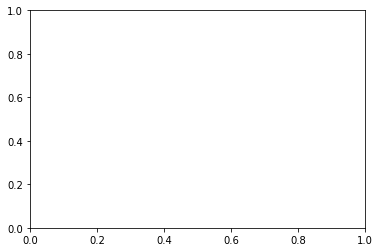

In [336]:
result = results['libmonitor.so.0.0.0']
print(result)
ax = sns.distplot(result, rug=True, rug_kws={"color": "g"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 1, "color": "g"})

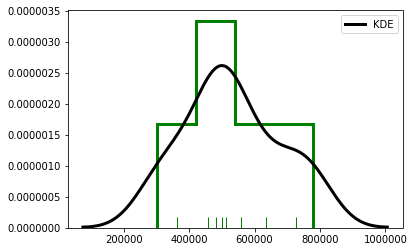

In [140]:
result = results['cpi']
ax = sns.distplot(result, rug=True, rug_kws={"color": "g"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 1, "color": "g"})

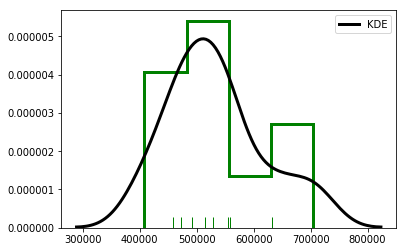

In [141]:
result = results['libmpi.so.12.0.5']
ax = sns.distplot(result, rug=True, rug_kws={"color": "g"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 1, "color": "g"})

In [18]:
dataset = 'calc-pi-random-0'
state = read_gf(dataset)
print(state.df)

                      node  rank                  node.1  rank.1  time (inc)  \
0           <program root>     0          <program root>       0  369,192.38   
1           <program root>     1          <program root>       1  896,301.39   
2           <program root>     2          <program root>       2  820,467.32   
3           <program root>     3          <program root>       3   70,921.77   
4                     main     0                    main       0  853,983.23   
..                     ...   ...                     ...     ...         ...   
17       294:MPID_Finalize     2       294:MPID_Finalize       2  184,919.12   
18       294:MPID_Finalize     3       294:MPID_Finalize       3  681,082.94   
19  162:MPIDI_CH3_Finalize     1  162:MPIDI_CH3_Finalize       1  677,831.25   
20  162:MPIDI_CH3_Finalize     2  162:MPIDI_CH3_Finalize       2  732,535.01   
21  162:MPIDI_CH3_Finalize     3  162:MPIDI_CH3_Finalize       3  112,211.83   

    time  nid  rank.1.1                

AxesSubplot(0.125,0.125;0.775x0.755)


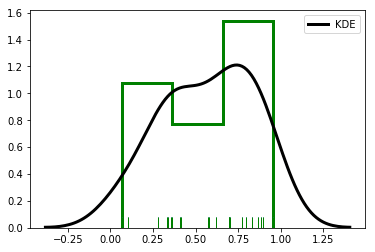

In [19]:
random = np.random.rand(state.df.shape[0])
ax = sns.distplot(random, hist=False, rug=True);
print(ax)

ax = sns.distplot(random, rug=True, rug_kws={"color": "g"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                  hist_kws={"histtype": "step", "linewidth": 3,
                            "alpha": 1, "color": "g"})

In [20]:
def iqr(a):
    """Calculate the IQR for an array of numbers."""
    a = np.asarray(a)
    q1 = stats.scoreatpercentile(a, 25)
    q3 = stats.scoreatpercentile(a, 75)
    return q3 - q1

In [21]:
def _freedman_diaconis_bins(a):
    """Calculate number of hist bins using Freedman-Diaconis rule."""
    # From https://stats.stackexchange.com/questions/798/
    a = np.asarray(a)
    if len(a) < 2:
        return 1
    h = 2 * iqr(a) / (len(a) ** (1 / 3))
    # fall back to sqrt(a) bins if iqr is 0
    if h == 0:
        return int(np.sqrt(a.size))
    else:
        return int(np.ceil((a.max() - a.min()) / h))

In [22]:
 def kde(data, gridsize=512, fft=True, kernel='gau', bw='scott', cut=3, clip=(-np.inf, np.inf)):
        print("Data is ", data)
        
        # assign binwidth using scott's factor
        if bw == 'scott':
            bw = stats.gaussian_kde(data).scotts_factor() * data.std(ddof=1)
        print("biwidth is: ", bw)    
        
        kde = smnp.KDEUnivariate(data)
        kde_gau = stats.gaussian_kde(data, bw_method=bw)
        
        # create the grid to fit the estimation.
        # clip = (0, data.max())
        # print(clip)
        support_min = max(data.min() - bw * cut, clip[0])
        support_max = min(data.max() + bw * cut, clip[1])
#         support_min = max(0, clip[0])
#         support_max = min(data.max(), clip[1])
        grid = np.linspace(support_min, support_max, gridsize)
        clip = (support_min, support_max)
        print("Grid is: ", grid.shape)
        
        kde.fit("gau", bw, fft, gridsize=gridsize, cut=cut, clip=clip)
        y = kde.density
        print("Y is: ", y.shape)
        x = grid
                
        return grid, y

In [23]:
def sshist(x, N=range(2, 501), SN=30):
    """
    Returns the optimal number of bins in a histogram used for density
    estimation.
    Optimization principle is to minimize expected L2 loss function between
    the histogram and an unknown underlying density function.
    An assumption made is merely that samples are drawn from the density
    independently each other.
    The optimal binwidth D* is obtained as a minimizer of the formula,
    (2K-V) / D^2,
    where K and V are mean and variance of sample counts across bins with width
    D. Optimal number of bins is given as (max(x) - min(x)) / D.
    Parameters
    ----------
    x : array_like
        One-dimensional data to fit histogram to.
    N : array_like, optional
        Array containing number of histogram bins to evaluate for fit.
        Default value = 500.
    SN : double, optional
        Scalar natural number defining number of bins for shift-averaging.
    Returns
    -------
    optN : int
        Optimal number of bins to represent the data in X
    N : double
        Maximum number of bins to be evaluated. Default value = 500.
    C : array_like
        Cost function C[i] of evaluating histogram fit with N[i] bins
    See Also
    --------
    sskernel, ssvkernel
    References
    ----------
    .. [1] H. Shimazaki and S. Shinomoto, "A method for selecting the bin size
           of a time histogram," in  Neural Computation 19(6), 1503-1527, 2007
           http://dx.doi.org/10.1162/neco.2007.19.6.1503
    """

    # determine range of input 'x'
    x_min = np.min(x)
    x_max = np.max(x)

    # get smallest difference 'dx' between all pairwise samples
    buf = np.abs(np.diff(np.sort(x)))
    dx = min(buf[buf > 0])

    # setup bins to evaluate
    N_MIN = 2
    N_MAX = min(np.floor((x_max - x_min) / (2*dx)), max(N))
    N_MAX = N_MAX.astype(int)  
    N = range(N_MIN, N_MAX+1)
    D = (x_max - x_min) / N

    # compute cost function over each possible number of bins
    Cs = np.zeros((len(N), SN))
    for i, n in enumerate(N):  # loop over number of bins
        shift = np.linspace(0, D[i], SN)
        for p, sh in enumerate(shift):  # loop over shift window positions

            # define bin edges
            edges = np.linspace(x_min + sh - D[i]/2,
                                x_max + sh - D[i]/2, N[i]+1)

            # count number of events in these bins
            ki = np.histogram(x, edges)

            # get mean and variance of events
            k = ki[0].mean()
            v = np.sum((ki[0] - k)**2) / N[i]

            Cs[i, p] = (2*k - v) / D[i]**2

    # average over shift window
    C = Cs.mean(axis=1)
    
    # get bin count that minimizes cost C
    idx = np.argmin(C)
    optN = N[idx]
    optD = D[idx]
    edges = np.linspace(x_min, x_max, optN)

    return optN, optD, edges, C, N

In [24]:
data = [999560.5, 522136.93900397, 505126.27075341, 714996.49335358, 565991.23472955]
sshist(data)

(2,
 247217.114623295,
 array([505126.27075341, 999560.5       ]),
 array([3.74968151e-11, 5.20864850e-11, 5.97222000e-11, 7.36301096e-11,
        8.71289631e-11, 1.07445419e-10, 1.31852437e-10, 1.48078332e-10,
        1.68394788e-10, 1.87620428e-10, 2.04937139e-10, 2.19526808e-10,
        2.34389182e-10]),
 range(2, 15))

In [25]:
def ssvkernel(x, tin=None, M=80, nbs=1e2, WinFunc='Boxcar'):
    """
    Generates a locally adaptive kernel-density estimate for one-dimensional
    data.
    The user provides a one-dimensional vector of samples drawn from some
    underlying unknown distribution, and optionally the values where they want
    to estimate the probability density of that distribution. The algorithm
    solves an optimization problem to identify variable bandwidths across the
    domain where the data is provided.
    The optimization is based on a principle of minimizing expected L2 loss
    function between the kernel estimate and an unknown underlying density
    function. An assumption is merely that samples are drawn from the density
    independently of each other.
    The locally adaptive bandwidth is obtained by iteratively computing optimal
    fixed-size bandwidths wihtihn local intervals. The optimal bandwidths are
    selected such that they are selected in the intervals that are gamma times
    larger than the optimal bandwidths themselves. The paramter gamma is
    optimized by minimizing the L2 risk estimate.
    Parameters
    ----------
    x : array_like
        The one-dimensional samples drawn from the underlying density
    tin : array_like, optional
        The values where the density estimate is to be evaluated in generating
        the output 'y'. Default value = None.
    M : int, optional
        The number of window sizes to evaluate. Default value = 80.
    nbs : int, optional
        The number of bootstrap samples to use in estimating the [0.05, 0.95]
        confidence interval of the output 'y'.
    WinFunc : string, optional
        The type of window function to use in estimating local bandwidth.
        Choose from one of 'Boxcar', 'Laplace', 'Cauchy' and 'Gauss'. Default
        value = 'Gauss'.
    Returns
    -------
    y : array_like
        The estimated density, evaluated at points t / tin.
    t : array_like
        The points where the density estimate 'y' is evaluated.
    optw : array_like
        The optimal local kernel bandwidths at 't'.
    gs : array_like
        The stiffness constants of the variables bandwidths evaluated.
    C : array_like
        Cost functions associated with stiffness constraints.
    confb95 : array_like
        The 5% and 95% confidence interval of the kernel density estimate 'y'.
        Has dimensions 2 x len(y). confb95[0,:] corresponds to the 5% interval,
        and confb95[1,:] corresponds to the 95% interval.
    yb : array_like
        The bootstrap samples used in estimating confb95. Each row corresponds
        to one bootstrap sample.
    See Also
    --------
    sshist, sskernel
    References
    ----------
    .. [1] H. Shimazaki and S. Shinomoto, "Kernel Bandwidth Optimization in 
           Spike Rate Estimation," in Journal of Computational Neuroscience 
           29(1-2): 171–182, 2010 http://dx.doi.org/10.1007/s10827-009-0180-4
    """

    # set argument 't' if not provided
    if tin is None:
        T = np.max(x) - np.min(x)
        dx = np.sort(np.diff(np.sort(x)))
        dt_samp = dx[np.nonzero(dx)][0]
        tin = np.linspace(np.min(x), np.max(x), min(np.ceil(T / dt_samp), 1e3))
        t = tin
        print(min(tin), max(tin),(x >= min(tin)) & (x <= max(tin)) )
#         x_ab = x[bool(x >= min(tin)) & (x <= max(tin))]
        x_ab = x
    else:
        T = np.max(x) - np.min(x)
        x_ab = x[(x >= min(tin)) & (x <= max(tin))]
        dx = np.sort(np.diff(np.sort(x)))
        dt_samp = dx[np.nonzero(dx)][0]
        if dt_samp > min(np.diff(tin)):
            t = np.linspace(min(tin), max(tin), min(np.ceil(T / dt_samp), 1e3))
        else:
            t = tin

    # calculate delta t
    dt = min(np.diff(t))

    # create the finest histogram
    thist = np.concatenate((t, (t[-1]+dt)[np.newaxis]))
    y_hist = np.histogram(x_ab, thist-dt/2)[0] / dt
    L = y_hist.size
    N = sum(y_hist * dt).astype(np.float)

    # initialize window sizes
    W = logexp(np.linspace(ilogexp(5 * dt), ilogexp(T), M))

    # compute local cost functions
    c = np.zeros((M, L))
    for j in range(M):
        w = W[j]
        yh = fftkernel(y_hist, w / dt)
        c[j, :] = yh**2 - 2 * yh * y_hist + 2 / (2 * np.pi)**0.5 / w * y_hist

    # initialize optimal ws
    optws = np.zeros((M, L))
    for i in range(M):
        Win = W[i]
        C_local = np.zeros((M, L))
        for j in range(M):
            C_local[j, :] = fftkernelWin(c[j, :], Win / dt, WinFunc)
        n = np.argmin(C_local, axis=0)
        optws[i, :] = W[n]

    # golden section search for stiffness parameter of variable bandwidths
    k = 0
    gs = np.zeros((30, 1))
    C = np.zeros((30, 1))
    tol = 1e-5
    a = 1e-12
    b = 1
    phi = (5**0.5 + 1) / 2
    c1 = (phi - 1) * a + (2 - phi) * b
    c2 = (2 - phi) * a + (phi - 1) * b
    f1 = CostFunction(y_hist, N, t, dt, optws, W, WinFunc, c1)[0]
    f2 = CostFunction(y_hist, N, t, dt, optws, W, WinFunc, c2)[0]
    while (np.abs(b-a) > tol * (abs(c1) + abs(c2))) & (k < 30):
        if f1 < f2:
            b = c2
            c2 = c1
            c1 = (phi - 1) * a + (2 - phi) * b
            f2 = f1
            f1, yv1, optwp1 = CostFunction(y_hist, N, t, dt, optws, W,
                                           WinFunc, c1)
            yopt = yv1 / np.sum(yv1 * dt)
            optw = optwp1
        else:
            a = c1
            c1 = c2
            c2 = (2 - phi) * a + (phi - 1) * b
            f1 = f2
            f2, yv2, optwp2 = CostFunction(y_hist, N, t, dt, optws, W,
                                           WinFunc, c2)
            yopt = yv2 / np.sum(yv2 * dt)
            optw = optwp2

        # capture estimates and increment iteration counter
        gs[k] = c1
        C[k] = f1
        k = k + 1

    # discard unused entries in gs, C
    gs = gs[0:k]
    C = C[0:k]

    # estimate confidence intervals by bootstrapping
    nbs = np.asarray(int(nbs))
    print(nbs)
    yb = np.zeros((nbs, tin.size))
    print(yb)
    for idx in range(nbs):
        Nb = np.random.poisson(lam=N)
        idx = np.random.randint(0, N, Nb)
        xb = x_ab[idx]
        thist = np.concatenate((t, (t[-1]+dt)[np.newaxis]))
        y_histb = np.histogram(xb, thist - dt / 2)[0]
        idx = y_histb.nonzero()
        y_histb_nz = y_histb[idx]
        t_nz = t[idx]
        yb_buf = np.zeros((L, ))
        for k in range(L):
            yb_buf[k] = np.sum(y_histb_nz * Gauss(t[k] - t_nz, optw[k])) / Nb
        yb_buf = yb_buf / np.sum(yb_buf * dt)
        yb[i, :] = np.interp(tin, t, yb_buf)
    ybsort = np.sort(yb, axis=0)
    y95b = ybsort[np.int(np.floor(0.05 * nbs)), :]
    y95u = ybsort[np.int(np.floor(0.95 * nbs)), :]
    confb95 = np.concatenate((y95b[np.newaxis], y95u[np.newaxis]), axis=0)

    # return outputs
    y = np.interp(tin, t, yopt)
    optw = np.interp(tin, t, optw)
    t = tin

    return y, t, optw, gs, C, confb95, yb


def CostFunction(y_hist, N, t, dt, optws, WIN, WinFunc, g):

    L = y_hist.size
    optwv = np.zeros((L, ))
    for k in range(L):
        gs = optws[:, k] / WIN
        if g > np.max(gs):
            optwv[k] = np.min(WIN)
        else:
            if g < min(gs):
                optwv[k] = np.max(WIN)
            else:
                idx = np.max(np.nonzero(gs >= g))
                optwv[k] = g * WIN[idx]

    # Nadaraya-Watson kernel regression
    optwp = np.zeros((L, ))
    for k in range(L):
        if WinFunc == 'Boxcar':
            Z = Boxcar(t[k]-t, optwv / g)
        elif WinFunc == 'Laplace':
            Z = Laplace(t[k]-t, optwv / g)
        elif WinFunc == 'Cauchy':
            Z = Cauchy(t[k]-t, optwv / g)
        else:  # WinFunc == 'Gauss'
            Z = Gauss(t[k]-t, optwv / g)
        optwp[k] = np.sum(optwv * Z) / np.sum(Z)

    # speed-optimized baloon estimator
    idx = y_hist.nonzero()
    y_hist_nz = y_hist[idx]
    t_nz = t[idx]
    yv = np.zeros((L, ))
    for k in range(L):
        yv[k] = np.sum(y_hist_nz * dt * Gauss(t[k]-t_nz, optwp[k]))
    yv = yv * N / np.sum(yv * dt)

    # cost function of estimated kernel
    cg = yv**2 - 2 * yv * y_hist + 2 / (2 * np.pi)**0.5 / optwp * y_hist
    Cg = np.sum(cg * dt)

    return Cg, yv, optwp


def fftkernel(x, w):
    # forward padded transform
    L = x.size
    Lmax = L + 3 * w
    n = 2 ** np.ceil(np.log2(Lmax))
    X = np.fft.fft(x, n.astype(np.int))

    # generate kernel domain
    f = np.linspace(0, n-1, n) / n
    f = np.concatenate((-f[0: np.int(n / 2 + 1)],
                        f[1: np.int(n / 2 - 1 + 1)][::-1]))

    # evaluate kernel
    K = np.exp(-0.5 * (w * 2 * np.pi * f) ** 2)

    # convolve and transform back from frequency domain
    y = np.real(np.fft.ifft(X * K, n))
    y = y[0:L]

    return y


def fftkernelWin(x, w, WinFunc):
    # forward padded transform
    L = x.size
    Lmax = L + 3 * w
    n = 2 ** np.ceil(np.log2(Lmax))
    X = np.fft.fft(x, n.astype(np.int))

    # generate kernel domain
    f = np.linspace(0, n-1, n) / n
    f = np.concatenate((-f[0: np.int(n / 2 + 1)],
                        f[1: np.int(n / 2 - 1 + 1)][::-1]))
    t = 2 * np.pi * f

    # determine window function - evaluate kernel
    if WinFunc == 'Boxcar':
        a = 12**0.5 * w
        K = 2 * np.sin(a * t / 2) / (a * t)
        K[0] = 1
    elif WinFunc == 'Laplace':
        K = 1 / (1 + (w * 2 * np.pi * f)**2 / 2)
    elif WinFunc == 'Cauchy':
        K = np.exp(-w * np.abs(2 * np.pi * f))
    else:  # WinFunc == 'Gauss'
        K = np.exp(-0.5 * (w * 2 * np.pi * f)**2)

    # convolve and transform back from frequency domain
    y = np.real(np.fft.ifft(X * K, n))
    y = y[0:L]

    return y


def Gauss(x, w):
    y = 1 / (2 * np.pi)**2 / w * np.exp(-x**2 / 2 / w**2)
    return y


def Laplace(x, w):
    y = 1 / 2**0.5 / w * np.exp(-(2**0.5) / w / np.abs(x))
    return y


def Cauchy(x, w):
    y = 1 / (np.pi * w * (1 + (x / w)**2))
    return y


def Boxcar(x, w):
    a = 12**0.5 * w
    y = 1 / a
    y[np.abs(x) > a / 2] = 0
    return y


def logexp(x):
    y = np.zeros(x.shape)
    y[x < 1e2] = np.log(1+np.exp(x[x < 1e2]))
    y[x >= 1e2] = x[x >= 1e2]
    return y


def ilogexp(x):
    y = np.zeros(x.shape)
    y[x < 1e2] = np.log(np.exp(x[x < 1e2]) - 1)
    y[x >= 1e2] = x[x >= 1e2]
    return y

In [26]:
ssvkernel(data)

/Users/jarus/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:69: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/Users/jarus/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:238: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/Users/jarus/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:260: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
/Users/jarus/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:268: RuntimeWarning: invalid value encountered in true_divide


505126.27075341 999560.5 [ True  True  True  True  True]
100
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


TypeError: only integer scalar arrays can be converted to a scalar index

[8.090054780582496e-06, 4.045027390291252e-06, 0.0, 0.0, 4.045027390291252e-06, 0.0, 0.0, 0.0, 0.0, 4.045027390291252e-06]
[8.090054780582496e-06, 4.045027390291252e-06, 0.0, 0.0, 4.045027390291252e-06, 0.0, 0.0, 0.0, 0.0, 4.045027390291252e-06] <class 'list'>
10 11 [8.09005478e-06 4.04502739e-06 0.00000000e+00 0.00000000e+00
 4.04502739e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.04502739e-06] [505126.27075341 554569.69367807 604013.11660273 653456.53952739
 702899.96245205 752343.3853767  801786.80830136 851230.23122602
 900673.65415068 950117.07707534 999560.5       ]


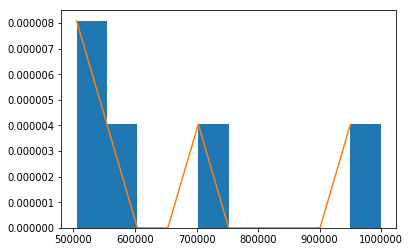

In [50]:
ser = 50*np.random.rand() * np.random.normal(10, 10, 100) + 20
ser = data
a = plt.hist(ser, normed=True)
x = list(a[0])
y = list(a[1])
y = y[0: len(y) - 1]
print(x)
plt.plot(y, x)
print(x, type(x))
print(len(a[0]), len(a[1]), a[0], a[1])